In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import sys
import keras
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras import initializers

Using TensorFlow backend.


In [2]:
from tqdm import tqdm  #because it's cool 

## Few Points from the paper

https://arxiv.org/pdf/1511.06434.pdf

    1.learning rate of 0.001 too high, use 0.0002 instead.  
    2.momentum term - 0.5 instead of 0.9.
    3.All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.
    4.mini-batch size of 128.

## Tips

   1. Problem: generated images look like noise. Solution: use dropout on both Discriminator and Generator. Low dropout values (0.3 to 0.6) generate more realistic images.
   2. Problem: Discriminator loss converges rapidly to zero thus preventing the Generator from learning. Solution: Do not pre-train the Discriminator. Instead make its learning rate bigger than the Adversarial model learning rate. Use a different training noise sample for the Generator.
   3. Problem: generator images still look like noise. Solution: check if the activation, batch normalization and dropout are applied in the correct sequence.
   4. Problem: figuring out the correct training/model parameters. Solution: start with some known working values from published papers and codes and adjust one parameter at a time. Before training for 2000 or more steps, observe the effect of parameter value adjustment at about 500 or 1000 steps.



z,random vector is only 10 for better results

https://github.com/soumith/ganhacks

## Loading MNIST Dataset

3


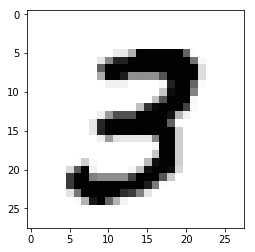

In [3]:
idx = 7  #change this see dofferent example
dir_path = os.getcwd()
f = open(dir_path+'/train-images.idx3-ubyte')
loaded = np.fromfile(f,np.uint8)

X_train= loaded[16:].reshape((60000,28,28)).astype(float)
X_train = (X_train - 127.5)/127.5
plt.imshow(X_train[idx],cmap='Greys')
f = open(dir_path+'/train-labels.idx1-ubyte')
loaded = np.fromfile(f,np.uint8)
Y_train = loaded[8:].reshape(60000).astype('uint8')
print(Y_train[idx])
X_train = (X_train.astype(np.float32) - 127.5)/127.5


# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

## Generator

Generator part of GANs

This needs to take noise as input and generate Image samples as output

In [4]:
def generator(X_input = Input(shape=(100,))):
    
    initializer = initializers.RandomNormal(mean=0,stddev=0.02)
    # Hidden layer with leaky relu
    X = Dense(units=256,input_dim= 100,kernel_initializer=initializer,name = 'Gen_Dense1')(X_input)
    X = LeakyReLU(alpha=0.2)(X)
#     print(X)
    X = Dense(units=512,name = 'Gen_Dense2')(X)
    X = LeakyReLU(0.2)(X)
#     print(X)
    X = Dense(1024,name = 'Gen_dense_3')(X)
    X = LeakyReLU(0.2)(X)
    X = Dense(784,activation='tanh')(X)
#     print(X)

    # Reshape output layer to the size of image 
    X = Reshape(target_shape=(28,28))(X)
    return X
    

Let's Test the Above function by and check the vale

(2, 28, 28)
<type 'numpy.ndarray'>


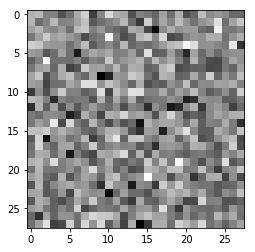

In [5]:
tf.reset_default_graph()
with tf.Session() as test:
    
    X1 = np.random.rand(2,100)
    X_i = tf.placeholder("float",shape=[None,100])
    los = generator(X_i)
    test.run(tf.global_variables_initializer())
    feed_dic = {
        X_i : X1
    }
    out = test.run(los,feed_dict=feed_dic)
    print(out.shape)
    print(type(out))
    plt.imshow(out[0],cmap='gray')
    


In [6]:
z = np.random.normal(size=(100,))
a = Input(shape=(100,))
gen_modelx = generator(a)
gen_modelx
gen_modelx.compile(loss='binary_entropy')
gen_modelx.predict(z)

AttributeError: 'Tensor' object has no attribute 'compile'

## Discriminator

In [7]:
def Discriminator(X_input):
    
    initializer = initializers.RandomNormal(mean=0,stddev=0.02)
    
    # Flatten the image to pass it through nn
    X = Flatten()(X_input)
    
    # Hidden Layers
    X = Dense(units=1024,kernel_initializer = initializer)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)
    
    X = Dense(units=512)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)  
#     print(X)
    
    X = Dense(units=256)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)   
    
    
    #Output Layer to predict fake or real
    X = Dense(units=1,activation='sigmoid')(X)
    return X
    

In [8]:
tf.reset_default_graph()
with tf.Session() as test:
    
    X1 = np.random.rand(1,28,28)
    X_i = tf.placeholder("float",shape=[None,28,28])
    los = Discriminator(X_i)
    test.run(tf.global_variables_initializer())
    feed_dic = {
        X_i : X1
    }
    out = test.run(los,feed_dict=feed_dic)
    print(out.shape)
    print(type(out))

    

(1, 1)
<type 'numpy.ndarray'>


In [9]:
def Discriminator_model(X_input_shape = (28,28)):
    X_input = Input(X_input_shape)
    X = Discriminator(X_input)
    model = Model(X_input,X,name = 'discriminator')
    return model

In [10]:
def Generator(X_input_shape = 100):
    X_input = Input(shape=(X_input_shape,))
    X = generator(X_input)
    model = Model(X_input,X,name = 'Generator')
    return model

## Combined Model

In [11]:
input_shape = 100
dis_model = Discriminator_model()
dis_model.compile(loss = 'binary_crossentropy',optimizer = Adam(lr = 0.0002,beta_1=0.5))

gen_model = Generator()
gen_model.compile(loss = 'binary_crossentropy',optimizer = Adam(lr = 0.0002,beta_1=0.5))

# Generated image to be used as input

dis_model.trainable = False
ganInput = Input(shape=(input_shape,))
x = gen_model(ganInput)
ganOutput = dis_model(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer= Adam(lr = 0.0002,beta_1=0.5))


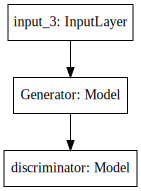

In [28]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(gan, to_file='gan.png',show_layer_names=False,show_shapes=True)
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

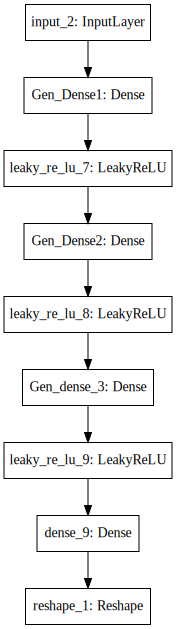

In [30]:
plot_model(gen_model,to_file='generator.png',show_layer_names=False,show_shapes=True)
SVG(model_to_dot(gen_model).create(prog='dot', format='svg'))

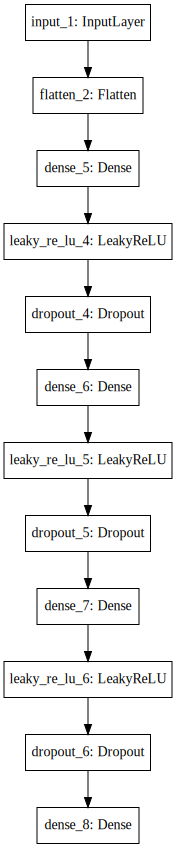

In [31]:
plot_model(dis_model,to_file='dis.png',show_layer_names=False,show_shapes=True)

SVG(model_to_dot(dis_model).create(prog='dot', format='svg'))

## Helper Functions

In [8]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, 100))

    # Generate images from random noise 
    gen_imgs = gen_model.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.savefig('Results/Gans-2/iter_'+str(iteration)+'.png')
    
    #save model too


In [ ]:
# Plot the loss from each batch
def plotLoss(d_loss,g_loss,epoch = 1):
    plt.figure(figsize=(10, 8))
    plt.plot(d_loss, label='Discriminitive loss')
    plt.plot(g_loss, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Results/Gans-2/gan_loss_epoch_%d.png' % epoch)

#after model.fit for all losses and metrics
print(model.history)
early_stopping - if validation cost is constant
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

## Build the Model

In [ ]:
ge

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

randomDim = 100
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch,examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = gen_model.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/my_gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST image
            generatedImages = gen_model.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X12 = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            dis_model.trainable = True
            dloss = dis_model.train_on_batch(X12, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            dis_model.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

 
        plotGeneratedImages(e)
#             saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(3, 128)



  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 3
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


  0%|          | 1/468 [00:00<01:10,  6.59it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<01:11,  6.53it/s]

--------------- Epoch 3 ---------------


 37%|███▋      | 174/468 [00:36<00:41,  7.06it/s]

In [ ]:
from tqdm import tqdm
for i in tqdm(range(1000)):
    sums += 1

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 3
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


  0%|          | 1/468 [00:00<01:18,  5.97it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<01:10,  6.61it/s]

--------------- Epoch 3 ---------------


100%|██████████| 468/468 [01:08<00:00,  6.68it/s]


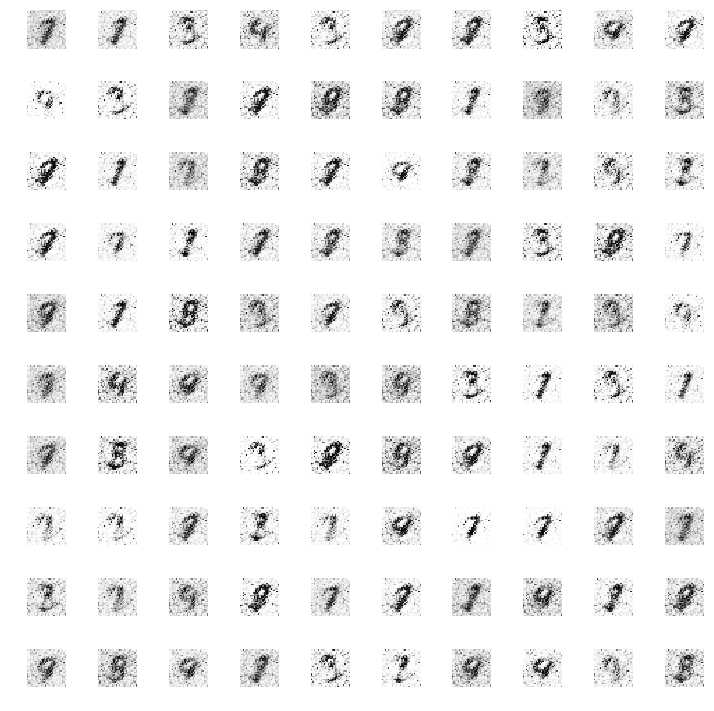

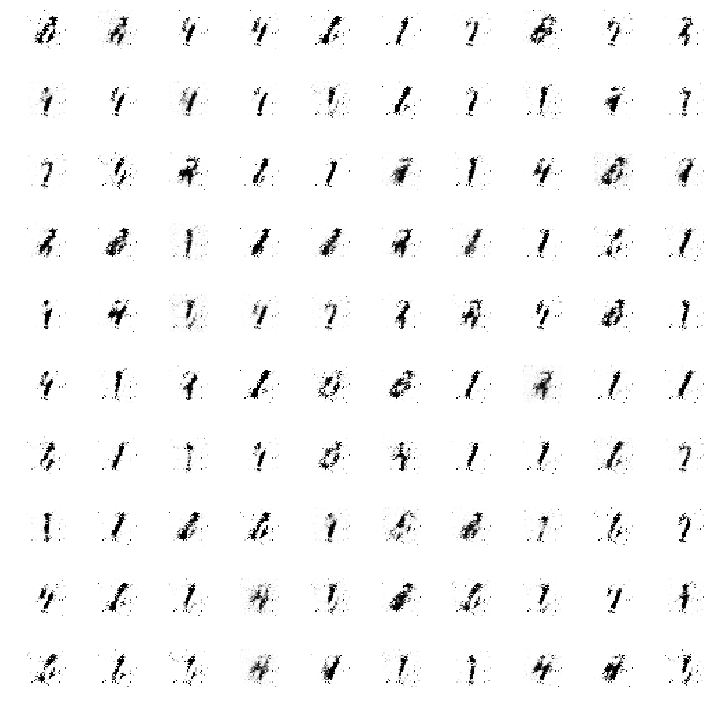

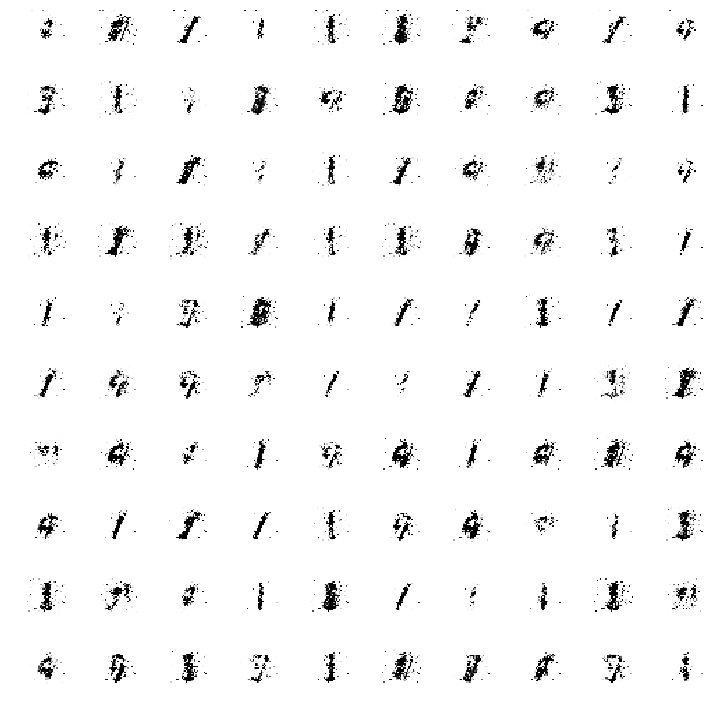

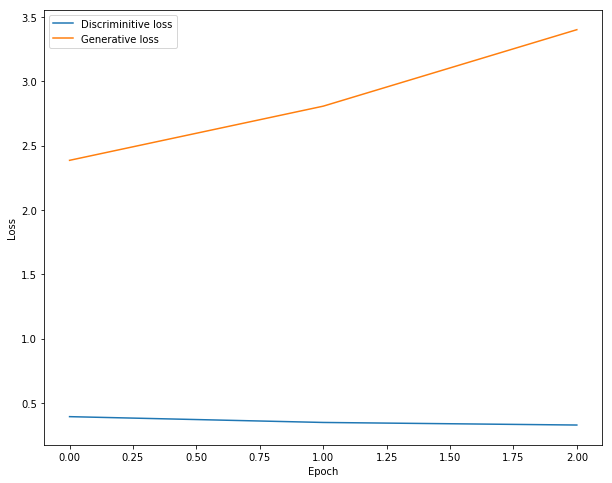

In [8]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)



# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
        plotGeneratedImages(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(3, 128)


In [6]:
adam = Adam(lr=0.0002, beta_1=0.5)
def gen(randomDim=100):
    generator = Sequential()
    generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(784, activation='tanh'))
    return generator
generator = gen()
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [7]:
def dis():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator
discriminator = dis()
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [10]:
def genx(X_input):
    
    initializer = initializers.RandomNormal(mean=0,stddev=0.02)
    # Hidden layer with leaky relu
    X = Dense(units=256,input_dim= 100,kernel_initializer=initializer,name = 'Gen_Dense1')(X_input)
    X = LeakyReLU(alpha=0.2)(X)
#     print(X)
    X = Dense(units=512,name = 'Gen_Dense2')(X)
    X = LeakyReLU(0.2)(X)
#     print(X)
    X = Dense(1024,name = 'Gen_dense_3')(X)
    X = LeakyReLU(0.2)(X)
    X = Dense(28*28,activation='tanh')(X)
#     print(X)

    # Reshape output layer to the size of image 
    X = Reshape(target_shape=(28,28))(X)
    return X

In [ ]:
dis = dis()
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [11]:
def disx(X_input):
    
    initializer = initializers.RandomNormal(mean=0,stddev=0.02)
    
    # Flatten the image to pass it through nn
    X = Flatten()(X_input)
    
    # Hidden Layers
    X = Dense(units=1024,kernel_initializer = initializer)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)
    
    X = Dense(units=512)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)  
    print(X)
    
    X = Dense(units=256)(X)
    X = LeakyReLU(alpha=.2)(X)
    X = Dropout(0.3)(X)   
    
    
    #Output Layer to predict fake or real
    X = Dense(units=1,activation='sigmoid')(X)
    return X